# EECE5644 Summer 2 2022 - HW3

Going over "solutions" for Assignment 3.

## Imports

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import norm, multivariate_normal as mvn

from sklearn.model_selection import KFold 

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [2]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(len(pdf_params['priors'])))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l] <= u) & (u <= thresholds[l+1]))[:, 0]
        # No. of samples in this component
        N_labels = len(indices)  
        labels[indices] = l * np.ones(N_labels)
        X[indices, :] =  mvn.rvs(pdf_params['mu'][l], pdf_params['Sigma'][l], N_labels)
    
    return X, labels

## Question 1

In this exercise, you will train many multilayer perceptrons (MLPs) to approximate class label posteriors. The MLPs will be trained using maximum likelihood parameter estimation (or equivalently, minimum average cross-entropy loss). You will then use the trained models to approximate a maximum a posteriori (MAP) classification rule in an attempt to achieve minimum probability of error (i.e. minimize empirical risk with 0-1 loss assignments for correct-incorrect decisions).

### Data Distribution

For $C=4$ classes with uniform priors, specify Gaussian class-conditional pdfs for a 3-dimensional real-valued random vector $\mathbf{x}$. Pick your own mean vectors and covariance matrices for each class. Adjust these parameters of the multivariate Gaussian distribution so that the MAP classifier achieves between $10\%{-}20\%$ probability of error when using the true data pdf.

>Note that since we have uniform priors, then the MAP classifier reduces to a maximum likelihood (ML) classifier:

>\begin{equation*}
\hat{y} = \mathop{\rm argmax}_{j \in \{1, \ldots, C\}} p(\mathbf{x}\, | \, y=j).
\end{equation*}

>I selected the following parameters for my Gaussian class-conditional pdfs:

\begin{align*}
    \boldsymbol{\mu}_0 = \begin{bmatrix} 0\\ 0\\0 \end{bmatrix} \quad \quad
    \boldsymbol{\Sigma}_0 =\begin{bmatrix}1 & 0.3 & 1.4 \\ 0.3 & 1 & 0.3 \\ 1.4 & 0.3 & 7\end{bmatrix} \quad & \quad
    \boldsymbol{\mu}_1 =\begin{bmatrix}2\\0\\0\end{bmatrix} \quad \quad
    \boldsymbol{\Sigma}_1 =\begin{bmatrix}1 & -0.4 & -0.7 \\-0.4 & 1 & -0.4 \\ -0.7 & -0.4 & 3\end{bmatrix} \\
    \boldsymbol{\mu}_2 =\begin{bmatrix}4\\0\\0\end{bmatrix} \quad \quad
    \boldsymbol{\Sigma}_2 =\begin{bmatrix}1 & 0.4 & 0.7 \\0.4 & 1 & 0.4 \\ 0.7 & 0.4 & 3\end{bmatrix} \quad & \quad
    \boldsymbol{\mu}_3 =\begin{bmatrix}6\\0\\0\end{bmatrix} \quad \quad
    \boldsymbol{\Sigma}_3 =\begin{bmatrix}1 & -0.3 & -1.4 \\ -0.3 & 1 & -0.3 \\ -1.4 & -0.3 & 7\end{bmatrix}
\end{align*}

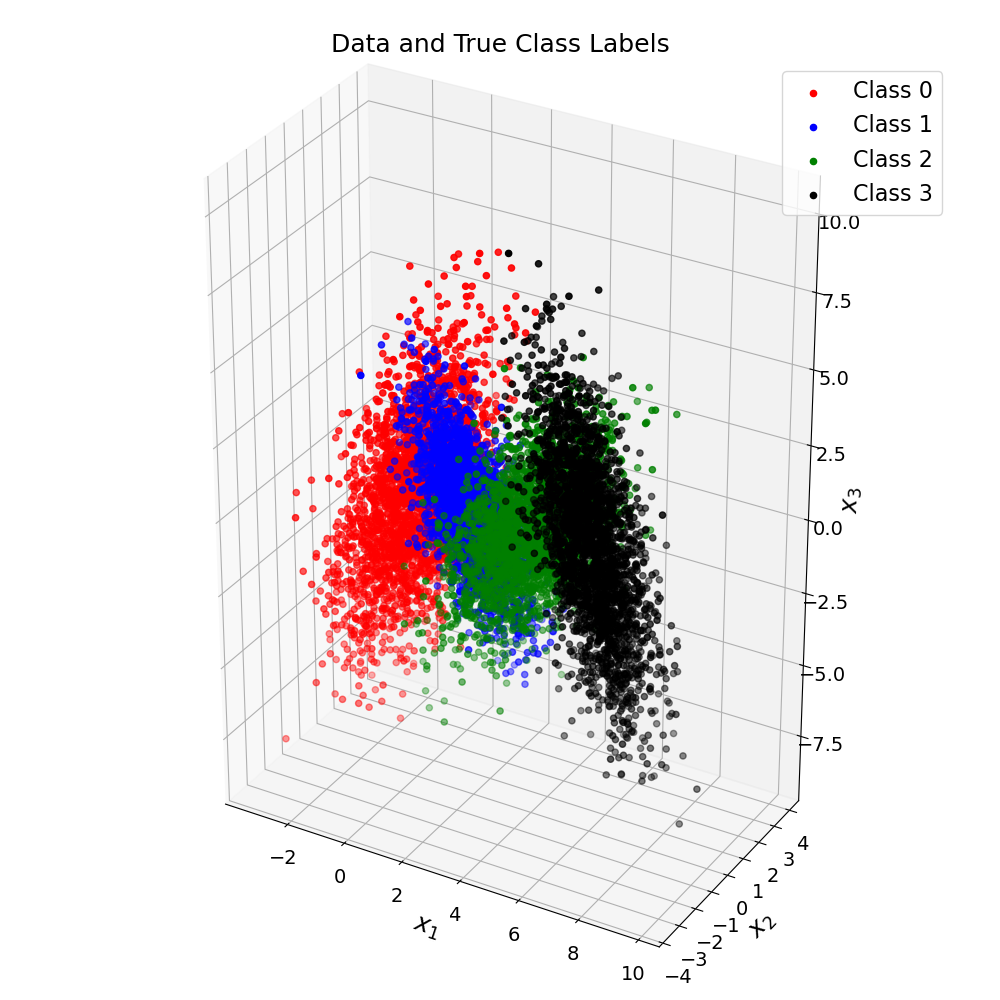

In [3]:
# Generate dataset to test out the four 3D multivariate Gaussian distributions
N = 10000

# Number of classes
C = 4

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.ones(C) / C  # uniform prior
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['mu'] = np.array([[0, 0, 0],
                         [2, 0, 0],
                         [4, 0, 0],
                         [6, 0, 0]])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([[[1, .3, 1.4],
                              [.3, 1, .3],
                              [1.4, .3, 7]],
                             [[1, -.4, -.7],
                              [-.4, 1, -.4],
                              [-.7, -.4, 3]],
                             [[1, .4, .7],
                              [.4, 1, .4],
                              [.7, .4, 3]],
                             [[1, -.3, -1.4],
                              [-.3, 1, -.3],
                              [-1.4, -.3, 7]]])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))

ax_raw = fig.add_subplot(111, projection='3d')

X, labels = generate_data_from_gmm(N, gmm_pdf)

ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels== 0, 2], c='r', label="Class 0")
ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='b', label="Class 1")
ax_raw.scatter(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2], c='g', label="Class 2")
ax_raw.scatter(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2], c='k', label="Class 3")
ax_raw.set_xlabel(r"$x_1$")
ax_raw.set_ylabel(r"$x_2$")
ax_raw.set_zlabel(r"$x_3$")
# Set equal axes for 3D plots
ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

### MLP Structure

Use a 2-layer MLP (one hidden layer of perceptrons) that has $P$ perceptrons in the first (hidden) layer with smooth-ramp style activation functions (e.g., Smooth-ReLU, ELU, etc), or ReLU. At the second/output layer use a softmax function to ensure all outputs are positive and sum up to 1 (representing $C$ probabilities). The best number of perceptrons, $P^*$, for your custom problem will be selected using $K$-fold cross-validation.

In [4]:
class TwoLayerMLP(nn.Module):
    # Two-layer neural network class
    
    def __init__(self, n, P, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from n -> P
        self.input_fc = nn.Linear(n, P)
        # Output layer again fully connected mapping from P -> C
        self.output_fc = nn.Linear(P, C)
        
    def forward(self, X):
        # X = [batch_size, input_dim]
        X = self.input_fc(X)
        # ReLU
        X = F.relu(X)
        # X = [batch_size, P]
        y = self.output_fc(X)
        return y

### Generate Data

Using your specified data distribution, generate multiple datasets: training sets with 100, 200, 500, 1000, 2000, 5000 samples and a test set with 100000 samples. You will use the <b>test set only for performance evaluation<b/>.

In [5]:
# Number of training input samples for experiments
N_train = [100, 200, 500, 1000, 2000, 5000]
# Number of test samples for experiments
N_test = 100000

# Lists to hold the corresponding input matrices, target vectors and sample label counts per training set
X_train = []
y_train = []
for N_i in N_train:
    print("Generating the training data set; Ntrain = {}".format(N_i))
    
    # Modulus to plot in right locations, hacking it
    X_i, y_i = generate_data_from_gmm(N_i, gmm_pdf)

    # Add to lists
    X_train.append(X_i)
    y_train.append(y_i)

print("Generating the test set; Ntest = {}".format(N_test))
X_test, y_test = generate_data_from_gmm(N_test, gmm_pdf)

print("All datasets generated!")

Generating the training data set; Ntrain = 100
Generating the training data set; Ntrain = 200
Generating the training data set; Ntrain = 500
Generating the training data set; Ntrain = 1000
Generating the training data set; Ntrain = 2000
Generating the training data set; Ntrain = 5000
Generating the test set; Ntest = 100000
All datasets generated!


### Theoretically Optimal Classifier

Using your knowledge of the true data pdf, construct a minimum-probability-of-error classifier. Then apply this optimal classifier to the test set and empirically estimate the probability of error for this theoretically optimal classifier. This provides the aspirational performance level for the MLP classifiers you will next develop.

In [6]:
# Conditional likelihoods of each x given each class, shape (C, N)
class_cond_likelihoods = np.array([mvn.pdf(X_test, gmm_pdf['mu'][i], gmm_pdf['Sigma'][i]) for i in range(C)])
decisions = np.argmax(class_cond_likelihoods, axis=0)
misclass_samples = sum(decisions != y_test)
min_prob_error = (misclass_samples / N_test)
print("Probability of Error on Test Set using the True Data PDF: {:.4f}".format(min_prob_error))

Probability of Error on Test Set using the True Data PDF: 0.1974


### Model Order Selection

For each of the training sets with a different number of samples, perform 10-fold cross-validation using minimum probability of error as the objective function to select the best number of perceptrons $P$ (as justified by available training data). This will involve you training multiple MLPs on each of the six training sets: one per $k$-fold, per chosen $P$.

>Below I first define two functions that implement generic training/evaluation routines for a PyTorch model:

In [7]:
def model_train(model, data, labels, optimizer, criterion=nn.CrossEntropyLoss(), num_epochs=100):
    # Set this "flag" before training
    model.train()
    # Optimize the model, e.g. a neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model, loss

def model_predict(model, data):
    # Similar idea to model.train(), set a flag to let network know your in "inference" mode
    model.eval()
    # Disabling gradient calculation is useful for inference, only forward pass!!
    with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = model(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().numpy()

        return np.argmax(predicted_labels, 1)

>A review of the $K$-fold CV algorithm from your lecture notes is also provided:

>1) Partition $\mathcal{D}$ into $\mathcal{D}_1, \mathcal{D}_2, \ldots, \mathcal{D}_K$ with equal partition sizes (or close)

>2) for model $m \in \{1,\ldots,M\}$

>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for fold $k \in \{1,\ldots,K\}$

>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\mathcal{D}_\text{valid-k} = \mathcal{D}_k \, ; \, \mathcal{D}_\text{train-k}=\mathcal{D}-\mathcal{D}_k$

>&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\boldsymbol{\theta}^*_{m,k} = \displaystyle \mathop{\rm argmin}_{\boldsymbol{\theta}_m} \mathcal{L}_\text{train}(\boldsymbol{\theta}_m; \mathcal{D}_\text{train-k})$

>&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;           $\epsilon_{m,k}=\mathcal{L}_\text{valid}(\boldsymbol{\theta}^*_{m,k};\mathcal{D}_\text{valid-k})$

>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        $\displaystyle \epsilon_{m}=\frac{1}{K}\sum_{k=1}^K \epsilon_{m,k}$

>3) "Best" model has smallest average error: $\displaystyle m^* = \mathop{\rm argmin}_{m\in\{1,\ldots,M\}}\epsilon_m$

>4) Given $m^*$, train on entire dataset: $\displaystyle \boldsymbol{\theta}^*_{m^*} = \mathop{\rm argmin}_{\boldsymbol{\theta}_{m^*}} \mathcal{L}_\text{train}(\boldsymbol{\theta}_{m^*};\mathcal{D})$

>The snippet of code below implements this algorithm, selecting the optimal number of perceptrons $P^*$ as the choice of best model $m^*$. Within the cross-validation algorithm, our previous model training and evaluation methods are applied to acquire the maximum likelihood estimate of the parameters for an MLP with a configured $P$, as well as perform predictions using this network on the validation fold.

In [8]:
def k_fold_cv_perceptrons(K, P_list, data, labels):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    error_valid_mk = np.zeros((len(P_list), K)) 

    # STEP 2: Iterate over all model options based on number of perceptrons
    # Track model index
    m = 0
    for P in P_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            # Extract the training and validation sets from the K-fold split
            # Convert numpy structures to PyTorch tensors, necessary data types
            X_train_k = torch.FloatTensor(data[train_indices])
            y_train_k = torch.LongTensor(labels[train_indices])

            model = TwoLayerMLP(X_train_k.shape[1], P, C)

            # Stochastic GD with learning rate and momentum hyperparameters
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            
            # Trained model
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)

            X_valid_k = torch.FloatTensor(data[valid_indices])
            y_valid_k = labels[valid_indices]
            
            # Evaluate the neural network on the validation fold
            predictions = model_predict(model, X_valid_k)
            # Retain the probability of error estimates
            error_valid_mk[m, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        m += 1
    
    # STEP 3: Compute the average prob. error (across K folds) for that model
    error_valid_m = np.mean(error_valid_mk, axis=1) 
    
    # Return the optimal choice of P* and prepare to train selected model on entire dataset
    optimal_P = P_list[np.argmin(error_valid_m)]
    
    return optimal_P, error_valid_m

>Now we report the optimal number of perceptrons $P^*$ per training set:

	# of Training Samples 	Best # of Perceptrons 	Pr(error)
		 100 			 128 		  0.220
		 200 			 128 		  0.205
		 500 			 512 		  0.208
		 1000 			 512 		  0.226
		 2000 			 512 		  0.213
		 5000 			 512 		  0.209


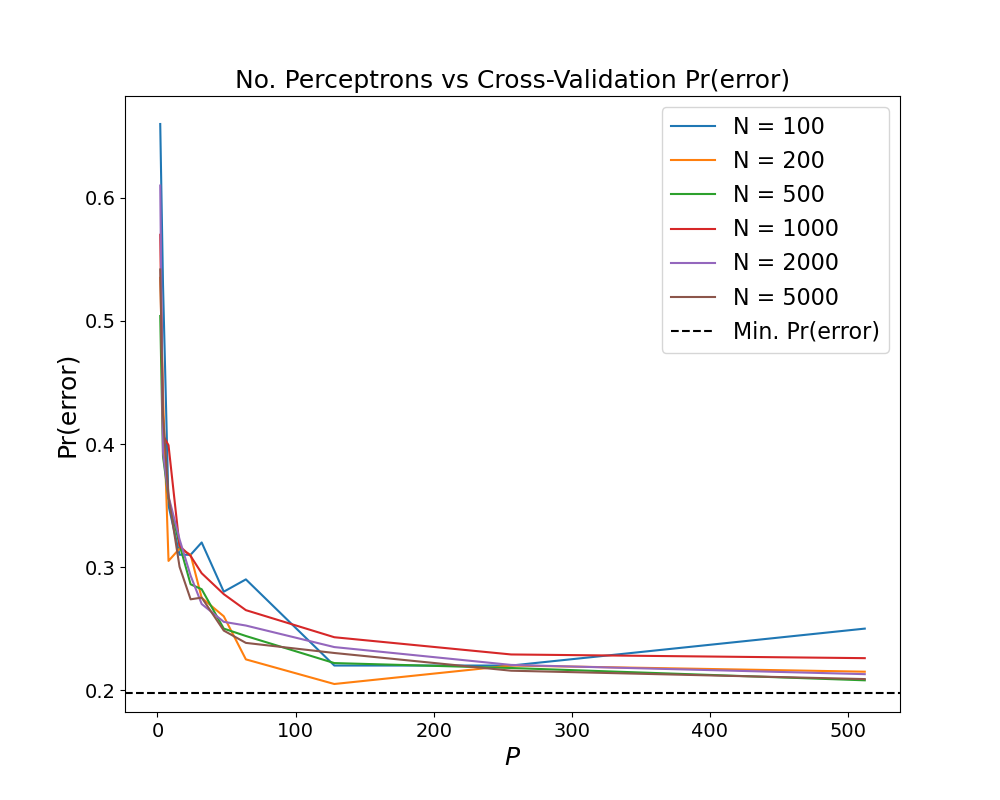

In [9]:
# Number of folds for CV
K = 10
P_list = [2, 4, 8, 16, 24, 32, 48, 64, 128, 256, 512]
# List of best no. of perceptrons for MLPs per training set
P_best_list = []

fig, ax = plt.subplots(figsize=(10, 8))

print("\t# of Training Samples \tBest # of Perceptrons \tPr(error)")
for i in range(len(X_train)):
    P_best, P_CV_err = k_fold_cv_perceptrons(K, P_list, X_train[i], y_train[i])
    P_best_list.append(P_best)
    print("\t\t %d \t\t\t %d \t\t  %.3f" % (N_train[i], P_best, np.min(P_CV_err)))
    ax.plot(P_list, P_CV_err, label="N = {}".format(N_train[i]))

plt.axhline(y=min_prob_error, color="black", linestyle="--", label="Min. Pr(error)")
ax.set_title("No. Perceptrons vs Cross-Validation Pr(error)")
ax.set_xlabel(r"$P$")
ax.set_ylabel("Pr(error)")
ax.legend();
plt.show()

> Would probably settle on fewer number of perceptrons than the best result of the CV algorithm, simply as this is likely overfitting, especially as we do not attempt to mitigate these effects via regularization in any way. Approximately $P=128$ might be a sufficient setting, or even less as the data is not especially complex or high-dimensional.

### Model Training

After identifying the optimal number of perceptrons $P^*$ per training set using cross-validation, now train an MLP with $P^*$ perceptrons via maximum likelihood parameter estimation (minimum cross-entropy loss) on each training set. Note that this will utilize all of the data in each training set, rather than $K-1$ folds of it as in cross-validation for hyperparameter selection of $P$. Hence, these are your final trained MLP models for the class posteriors, each with possibly a different number of perceptrons and different weights.

>Mitigate the chances of getting stuck at a local optimum by randomly reinitializing each MLP training routine multiple times and getting the highest training-data log-likelihood solution encountered.

In [10]:
# List of trained MlPs for later testing
trained_mlps = []
# Number of times to re-train same model with random re-initializations
num_restarts = 10

for i in range(len(X_train)):
    print("Training model for N = {}".format(X_train[i].shape[0]))
    X_i = torch.FloatTensor(X_train[i])
    y_i = torch.LongTensor(y_train[i])
    
    restart_mlps = []
    restart_losses = []
    # Remove chances of falling into suboptimal local minima
    for r in range(num_restarts):
        model = TwoLayerMLP(X_i.shape[1], P_best_list[i], C)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        # Trained model
        model, loss = model_train(model, X_i, y_i, optimizer)
        restart_mlps.append(model)
        restart_losses.append(loss.detach().item())

    # Add best model from multiple restarts to list
    trained_mlps.append(restart_mlps[np.argmin(restart_losses)])

Training model for N = 100
Training model for N = 200
Training model for N = 500
Training model for N = 1000
Training model for N = 2000
Training model for N = 5000


### Performance Assessment

Using each trained MLP as a model for the class posteriors, classify the samples in the test set using a MAP decision rule (aiming to minimize the probability of error). Empirically estimate the probability of error for each of the trained MLPs.

Probability of error results summarized below per trained MLP: 

	 # of Training Samples 	 Pr(error)
		 100 		   0.273
		 200 		   0.232
		 500 		   0.230
		 1000 		   0.221
		 2000 		   0.217
		 5000 		   0.213


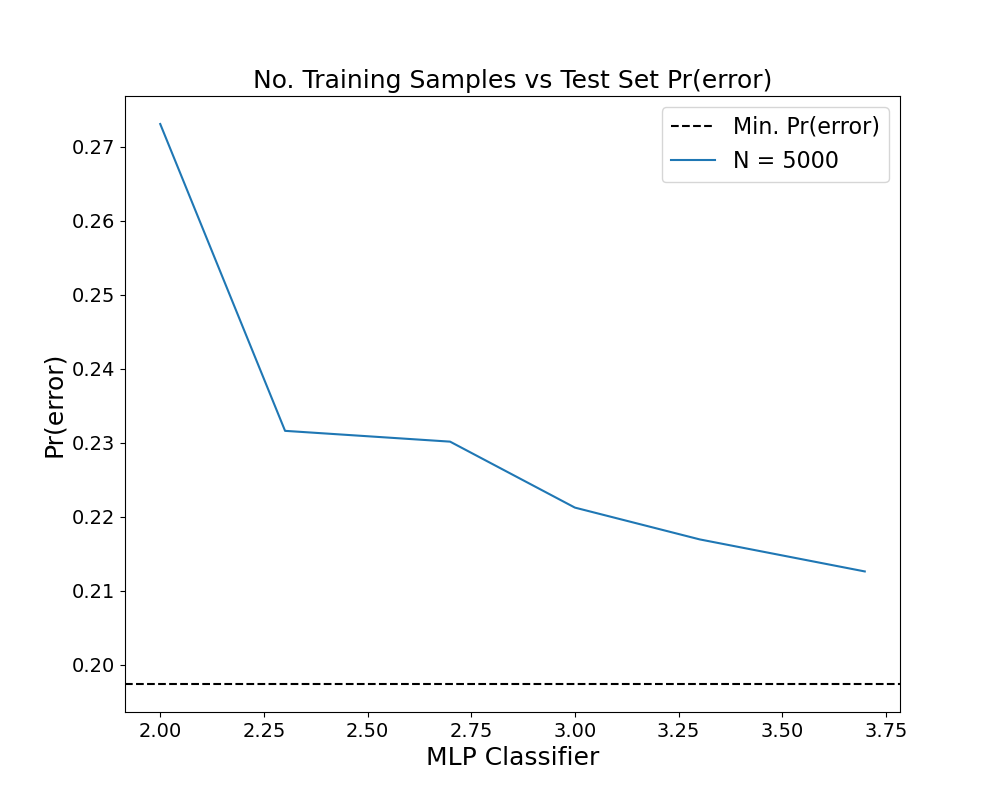

In [11]:
# First conver test set data to tensor suitable for PyTorch models
X_test_tensor = torch.FloatTensor(X_test)
pr_error_list = []

fig, ax = plt.subplots(figsize=(10, 8))

# Estimate loss (probability of error) for each trained MLP model by testing on the test data set
print("Probability of error results summarized below per trained MLP: \n")
print("\t # of Training Samples \t Pr(error)")
for i in range(len(X_train)):
    # Evaluate the neural network on the validation fold
    predictions = model_predict(trained_mlps[i], X_test_tensor)
    # Retain the probability of error estimates
    prob_error = np.sum(predictions != y_test) / len(y_test)
    print("\t\t %d \t\t   %.3f" % (N_train[i], prob_error))
    pr_error_list.append(prob_error)

plt.axhline(y=min_prob_error, color="black", linestyle="--", label="Min. Pr(error)")
ax.plot(np.log10(N_train), pr_error_list, label="N = {}".format(N_train[i]))
ax.set_title("No. Training Samples vs Test Set Pr(error)")
ax.set_xlabel("MLP Classifier")
ax.set_ylabel("Pr(error)")

#ax.set_xticks(np.log10(N_train))
ax.legend();
plt.show()

> Clear trend for improvements in probability of error as the amount of data supplied to the MLP classifier for model training increases.

## Question 2

In this question, you will derive the solution for <b>ridge regression</b> in the case of a linear model with additive white Gaussian noise corrupting both the input and output data. Then you will implement it and select the hyperparameter (prior's regularization parameter) via cross-validation. Use $n=10$, $N_{train}=50$, and $N_{test}=1000$ for this question.

### Generate Data 

Select an arbitrary non-zero $n$-dimensional vector $\mathbf{a}$. Pick an arbitrary Gaussian with nonzero-mean $\boldsymbol{\mu}$ and non-diagonal covariance matrix $\boldsymbol{\Sigma}$ for an $n$-dimensional random vector $\mathbf{x}$. Draw $N_{train}$ iid samples of $n$-dimensional samples of $\mathbf{x}$ from this Gaussian pdf. Draw $N_{train}$ iid samples of an $n$-dimensional random variable $\mathbf{z}$ from a zero-mean, $\epsilon \, \mathbf{I}$-covariance-matrix Gaussian pdf (noise corrupting the input). Draw $N_{train}$ iid samples of a scalar random variable $v$ from a zero-mean, unit-variance Gaussian pdf.  Calculate $N_{train}$ scalar values of a new random variable as follows $y=\mathbf{a}^\intercal(\mathbf{x}+\mathbf{z})+v$ using the samples of $\mathbf{x}$ and $v$. This is your training dataset that consists of $(\mathbf{x},y)$ pairs. Similarly, generate a separate test dataset that consists of $N_{test}$ $(\mathbf{x},y)$ pairs.

> For some arbitrary $\mathbf{a} \in \mathbb{R}^n$, we have $i=1, \ldots, N_{train}$ iid samples drawn from the following Gaussians:

>\begin{equation*}
\mathbf{x}^{(i)} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \in \mathbb{R}^n, \quad \mathbf{z}^{(i)} \sim \mathcal{N}(\mathbf{0}, \epsilon \mathbf{I}) \in \mathbb{R}^n, \quad v^{(i)} \sim \mathcal{N}(0, 1) \in \mathbb{R}.
\end{equation*}

> In my example, I specify $\mathbf{a} = \mathbf{1}$ and $\boldsymbol{\mu} = \mathbf{1}$ to be a fixed vector of ones. While the covariance matrix $\boldsymbol{\Sigma} = \mathbf{A}^\intercal\mathbf{A}$ is given as a [Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix) for a randomly sampled $\mathbf{A} \in \mathbb{R}^{n \times n}$, as this guarantees $\boldsymbol{\Sigma}$ to be positive semidefinite. Given these inputs, outputs are generated using:

>$$\mathbf{y}=(\mathbf{X}+\mathbf{Z})\mathbf{a} + \mathbf{v},$$

> with the above expression written in matrix form to stack the samples into a data matrix and target vector $\mathbf{y} = [y^{(1)} \, y^{(2)} \, \ldots \, y^{(N_{train})}]^\intercal \in \mathbb{R}^{N_{train}}$ consisting of all samples in the dataset.

> Provided with the given $n$ and $N_*$ above, let's now create a data-generating function for the training $\mathcal{D}_{train}$ and test $\mathcal{D}_{test}$ sets:

In [12]:
n = 10 # Dimensionality of the data
N_train = 50 # No. training set samples
N_test = 1000 # No. test set samples

# Fixed model parameters
a = np.ones(n)
mu = np.ones(n)
A = np.random.standard_normal(size=(n, n))
Sigma = A.T.dot(A)

def generate_q2_data(a, mu, Sigma, epsilon, N):
    # Draw samples from the data distributions plus noise variables 
    X = mvn.rvs(mu, Sigma, N)
    Z = mvn.rvs(np.zeros(n), epsilon * np.eye(n), N)
    v = norm.rvs(size=N)
    
    # Generate target vector
    y = (X + Z).dot(a) + v
    
    return X, y

> To begin with initial tests, I consider Gaussian noise model based on average variance in $\mathbf{x}$ by setting $\epsilon=\text{trace}(\boldsymbol{\Sigma})/n$.

In [13]:
# Scaled measure of average variance in the data 
epsilon_test = np.trace(Sigma) / n
X_train, y_train = generate_q2_data(a, mu, Sigma, epsilon_test, N_train)
X_test, y_test = generate_q2_data(a, mu, Sigma, epsilon_test, N_test)

### Model Parameter Estimation

We think that the relationship between the $(\mathbf{x},y)$ pairs is linear $y=\mathbf{w}^\intercal\mathbf{x}+w_0+v$, and that $v$ is an additive white Gaussian noise term (with zero-mean and unit-variance). We are unaware of the presence of the additional noise term $\mathbf{z}$ in the true generative process. We also believe that this process has linear model parameters close to zero, so we use a zero-mean, $\beta \, \mathbf{I}$-covariance-matrix Gaussian pdf as a prior $p(\boldsymbol{\theta})$ for the model parameters $\boldsymbol{\theta}=\mathbf{w}$ (which contain $w_0$). We will use MAP parameter estimation to determine the optimal weights for this model using the training data.

>We have $(\mathbf{x},y)$ pairs and we think the data is modeled by the linear relationship:

>$$y=\tilde{\mathbf{w}}^\intercal\tilde{\mathbf{x}}+v,$$

>where $\tilde{\mathbf{w}} = [w_0 \, \mathbf{w}]^\intercal \sim \mathcal{N}(0, \beta \, \mathbf{I})$, $\tilde{\mathbf{x}} = [1 \, \mathbf{x}]^\intercal \in \mathbb{R}^{n \times 1}$, and $v \sim \mathcal{N}(0, 1)$. We want to use MAP parameter estimation to determine the optimal weights $\tilde{\mathbf{w}}^*$ for this model using the training data $\mathcal{D}_{train}$. Recall that the MAP parameter estimate $\hat{\boldsymbol{\theta}}_{\text{MAP}}$ for an arbitrary model is given by:

>\begin{align}
\hat{\boldsymbol{\theta}}_{\text{MAP}} & = \mathop{\rm argmax}_{\boldsymbol{\theta}} \ln p(\boldsymbol{\theta}\, | \,\mathcal{D}_{train}) \\
& = \mathop{\rm argmax}_{\boldsymbol{\theta}} \ln p(\mathcal{D}_{train}\, | \,\boldsymbol{\theta}) + \ln p(\boldsymbol{\theta})  \\
& = \mathop{\rm argmin}_{\boldsymbol{\theta}} - \left[ \ln p(\mathcal{D}_{train}\, | \,\boldsymbol{\theta}) + \ln p(\boldsymbol{\theta}) \right],
\end{align}

> where the prior on $\boldsymbol{\theta} = \tilde{\mathbf{w}}$ has been specified as $p(\boldsymbol{\theta}) = \mathcal{N}(\tilde{\mathbf{w}} \, | \, \mathbf{0}, \beta \, \mathbf{I})$. For linear regression model $p(y \, | \, \tilde{\mathbf{x}}; \boldsymbol{\theta}) = \mathcal{N}\big(y \, | \, \tilde{\mathbf{w}}^\intercal \mathbf{\tilde{x}}, \sigma^2 \big)$ with fixed variance $\sigma^2 = 1$ from the additive Gaussian noise term $v$ (assumed independent of the data), our regularized minimization problem becomes:

> \begin{align} \hat{\boldsymbol{\theta}}_{\text{MAP}} & = \mathop{\rm argmin}_{\boldsymbol{\theta}} - \left[ \ln p(\mathcal{D}_{train}\, | \,\boldsymbol{\theta}) + \ln p(\boldsymbol{\theta}) \right] \\
& = \mathop{\rm argmin}_{\boldsymbol{\theta}} \frac{1}{2} \sum_{i=1}^{N_{train}} (y^{(i)} - \tilde{\mathbf{w}}^\intercal \mathbf{\tilde{x}}^{(i)})^2 + \frac{1}{2\beta}\tilde{\mathbf{w}}^\intercal \tilde{\mathbf{w}},
\end{align}

> which is equivalent to <b>ridge regression</b>. After finding the derivative of the above negative log-posterior expression and setting it to zero, we obtain the optimal MAP estimate:

>$$\tilde{\mathbf{w}}^* = (\mathbf{X}^\intercal\mathbf{X} + \frac{1}{\beta}\mathbf{I})^{-1}\mathbf{X}^\intercal\mathbf{y} = \left(\sum_{i=1}^{N_{train}} \tilde{\mathbf{x}}^{(i)}\tilde{\mathbf{x}}^{(i)\intercal} + \frac{1}{\beta}\mathbf{I}\right)^{-1}\left(\sum_{i=1}^{N_{train}} \tilde{\mathbf{x}}^{(i)} y^{(i)}\right) = \hat{\boldsymbol{\theta}}_{\text{MAP}}.$$

> Please follow the [HW2-Q2](hw2.ipynb#MAP-Estimation) solutions for a more fleshed out derivation. Below is the MAP parameter estimate in code (same as in HW2, except with $\beta$ as the regularization parameter):

In [14]:
def map_solution(X, y, beta):
    # MAP parameter solution is (X^T*X + (1/beta)*I)^-1 * X^T * y 
    return np.linalg.inv(X.T.dot(X) + (1 / beta)*np.eye(X.shape[1])).dot(X.T).dot(y)

### Hyperparameter Optimization

The prior $p(\boldsymbol{\theta})$ for the $(n{+}1)$-dimensional weight vector (plus bias $w_0$) in the model has a scalar parameter $\beta$ that needs to be selected. Use 5-fold cross-validation on the training set to select this parameter. As your cross-validation objective function, use max-log-likelihood of the validation data, averaged over the 5 folds of data. Utilize the MAP parameter estimation solution in the process with candidate hyperparameter values.

> We are applying the same CV techique as in <b>Q1</b>, however instead of selecting number of perceptrons $P$ for $K=10$ folds based on probability of error, we are now choosing $\beta$ for $K=5$ folds based on whichever value maximizes log-likelihood.

> Comparing candidate $\beta$ hyperparameter values using max. log-likelihood of the data as the cost function is equivalent to minimizing the negative log-likelihood:

>$$ \mathop{\rm argmin}_{\boldsymbol{\theta}} \text{NLL}(\boldsymbol{\theta}) = \mathop{\rm argmin}_{\boldsymbol{\theta}}\frac{1}{2} \sum_{i=1}^N (y^{(i)} - \tilde{\mathbf{w}}^\intercal \mathbf{\tilde{x}}^{(i)})^2.$$

>This is akin to minimizing the RSS loss function or MSE when averaged across $N$, with neglible constant terms that do not depend on $\tilde{\mathbf{w}}$ ignored in the optimization problem. Recap from the [MLE notebook](../linear_regression/lin_reg_mle.ipynb) on linear regression. Therefore given the MAP solution $\tilde{\mathbf{w}}^*$, the best $\beta$ can be chosen to instead minimize MSE:

In [15]:
def mse(y_preds, y_true):
    # Residual error (X * theta) - y
    error = y_preds - y_true
    # Loss function is MSE
    return np.mean(error ** 2)

def k_fold_cv_beta(K, beta_list, data, labels):
    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    mse_valid_mk = np.zeros((len(beta_list), K)) 

    # STEP 2: Iterate over all model options based on regularization parameter beta
    # Track model index
    m = 0
    for beta in beta_list:
        # K-fold cross validation
        k = 0
        for train_indices, valid_indices in kf.split(data):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_train[train_indices]
            y_train_k = y_train[train_indices]
            X_valid_k = X_train[valid_indices]
            y_valid_k = y_train[valid_indices]

            theta_mk = map_solution(X_train_k, y_train_k, beta)

            # Make predictions on the validation set
            y_valid_k_pred = X_valid_k.dot(theta_mk)

            # Record MSE as well for this model and k-fold
            mse_valid_mk[m, k] = mse(y_valid_k_pred, y_valid_k)
            k += 1
        m += 1

    # STEP 3: Compute the average MSE loss for that model (based in this case on beta)
    mse_valid_m = np.mean(mse_valid_mk, axis=1)
    
    # Return the optimal choice of beta* as the one that minimizes MSE     
    return beta_list[np.argmin(mse_valid_m)]

# 5-fold CV
K = 5
# Use geomspace to return 1000 evenly spaced numbers on a log scale with start-end points specified
n_betas = 1000
# Betas in the range 10^-7 to 10^7
betas = np.geomspace(10**-7, 10**7, num=n_betas)
beta_opt = k_fold_cv_beta(K, betas, X_train, y_train)
print("Best beta = %.4f for noise setting epsilon = %.2f" % (beta_opt, epsilon_test))

Best beta = 0.0075 for noise setting epsilon = 12.76


### Model Optimization \& Evaluation 

Once the best hyperparameter value is identified, use the entire training dataset to optimize the model parameters with MAP parameter estimation. Specifically use the best hyperparameter found from your model selection (cross-validation) procedure. Evaluate the "-2 $\times$ log-likelihood" of the trained model when applied to the test data.

In [16]:
theta_map = map_solution(X_train, y_train, beta_opt)
y_pred = X_test.dot(theta_map)
# Provided sigma = 1
log_lld = np.sum(norm.logpdf(y_test, loc=y_pred, scale=1))
# log_lld above is same as:
# log_lld = (N_test / 2) * np.log(2 * np.pi) + (1 / 2) * (y_test - y_pred).dot(y_test - y_pred).T
print("-2 x log-likelihood of the best beta model applied to the test set is %.1f" % (-2*log_lld))

-2 x log-likelihood of the best beta model applied to the test set is 152569.9


> Again refer to the [HW2-Q2](hw2.ipynb#ML-Estimation) solutions but we know that negative log-likelihood under this conditional Gaussian regression model is:

> $$\text{NLL}(\boldsymbol{\theta}) =\frac{N}{2}\ln(2\pi \sigma^2) + \frac{1}{2\sigma^2} \sum_{i=1}^N (y^{(i)} - \mathbf{w}^\intercal \mathbf{\tilde{x}}^{(i)})^2$$

> And so $2 \times \text{NLL}(\boldsymbol{\theta})$ is simply removing some of the constants in this expression and providing a measure of how well your model distribution fits the true data distribution. It is a common [statistical test](https://en.wikipedia.org/wiki/Wilks%27_theorem) for maximum-likelihood estimates (helps you compute what is known as a $p$-value). Proportional to the RSS loss function.

While keeping $\mathbf{a}$, $\boldsymbol{\mu}$, $\boldsymbol{\Sigma}$ constant, vary the noise parameter $\epsilon$ gradually from very small (e.g., $10^{-3} \times \text{trace}(\boldsymbol{\Sigma})/n$) to very large (e.g., $10^{3} \times \text{trace}(\boldsymbol{\Sigma})/n$), introducing increasing levels of noise to the input variable. Generate new training and test sets with each $\epsilon$, repeat the process, and analyze the impact of this noise parameter on the solution, selection of the hyperparameter, and performance on the test set.

Best beta = 3798215.3062 for noise setting epsilon = 0.01
Best beta = 38.9575 for noise setting epsilon = 0.07
Best beta = 93.1041 for noise setting epsilon = 0.40
Best beta = 409838.3672 for noise setting epsilon = 2.27
Best beta = 0.0557 for noise setting epsilon = 12.76
Best beta = 0.0002 for noise setting epsilon = 71.75
Best beta = 0.0050 for noise setting epsilon = 403.47
Best beta = 0.0017 for noise setting epsilon = 2268.91
Best beta = 0.0075 for noise setting epsilon = 12758.99


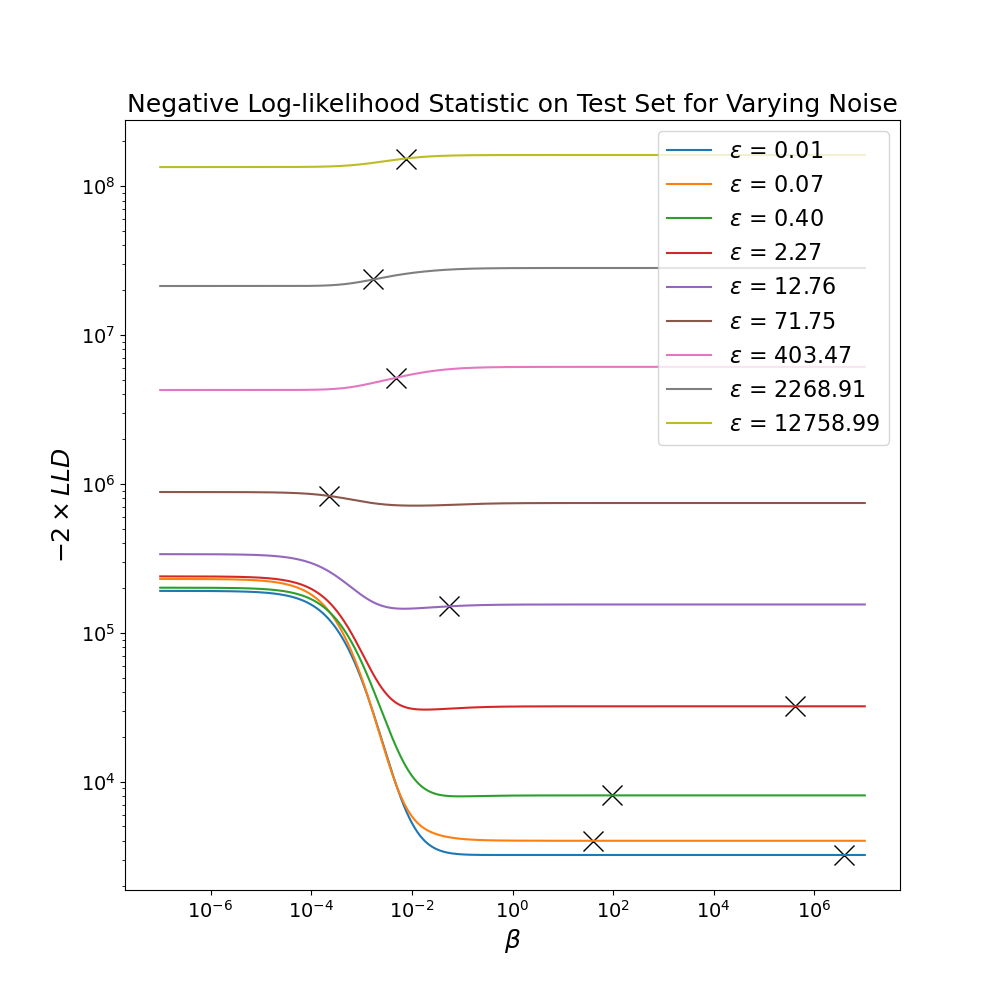

In [17]:
epsilons = np.geomspace(10**-3, 10**3, num=9)

fig = plt.figure(figsize=(10, 10))

for eps in epsilons:
    # Scaled measure of average variance in the data 
    eps *= np.trace(Sigma) / n

    # Generate training and test datasets
    X_train, y_train = generate_q2_data(a, mu, Sigma, eps, N_train)
    X_test, y_test = generate_q2_data(a, mu, Sigma, eps, N_test)
    
    beta_opt = k_fold_cv_beta(K, betas, X_train, y_train)
    print("Best beta = %.4f for noise setting epsilon = %.2f" % (beta_opt, eps))
    
    theta_map = map_solution(X_train, y_train, beta_opt)
    y_pred = X_test.dot(theta_map)
    log_lld_best = np.sum(norm.logpdf(y_test, loc=y_pred, scale=1))
    # Computing the -2xLLD values from the list betas to plot a line
    log_lld_betas = np.array([np.sum(norm.logpdf(y_test, 
                                        loc=X_test.dot(map_solution(X_train, y_train, b)), 
                                        scale=1)) for b in betas])
    
    plt.plot(beta_opt, -2*log_lld_best, 'kx', markersize=14)
    plt.plot(betas, -2*log_lld_betas, label=r"$\epsilon$ = {:.2f}".format(eps))

plt.title("Negative Log-likelihood Statistic on Test Set for Varying Noise")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$-2 \times LLD$")
plt.legend()
plt.show()

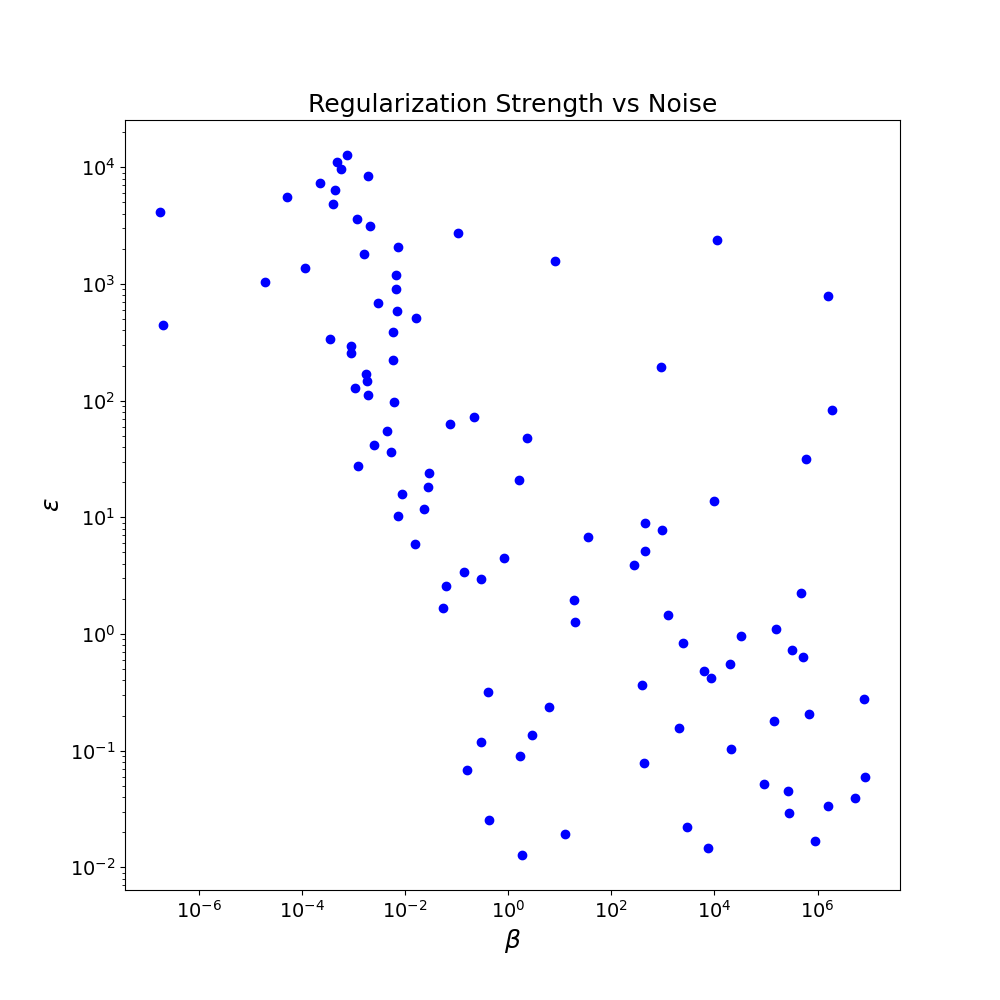

In [18]:
epsilons = np.geomspace(10**-3, 10**3, num=100)

fig = plt.figure(figsize=(10, 10))

for eps in epsilons:
    # Scaled measure of average variance in the data 
    eps *= np.trace(Sigma) / n

    # Generate training and test datasets
    X_train, y_train = generate_q2_data(a, mu, Sigma, eps, N_train)
    X_test, y_test = generate_q2_data(a, mu, Sigma, eps, N_test)
    
    beta_opt = k_fold_cv_beta(K, betas, X_train, y_train)
    
    plt.scatter(beta_opt, eps, color='blue')

plt.title("Regularization Strength vs Noise")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\epsilon$")
plt.show()

> As we increase the noise parameter $\epsilon$, the test statistic $-2 \times \text{LL}(\hat{\boldsymbol{\theta}}_{\text{MAP}})$ increases, which is expected given that the 10-dimensional input variable is now injected with high levels of noise. The black crosses for each noise level indicate the value of this log-likelihood stastic where our MAP parameter estimate is based on the optimal regularization parameter $\beta^*$ and applied to the test set.

> The second plot also demonstrates a slightly inverse relationship between the best regularization strength $\beta^*$ and the input's level of corruption. As higher values of $\beta$ correspond to diminished weighting by the prior and a parameter estimate akin to the ML estimate, it might be intuited that less regularization is required to compensate for overfitting. In other words, the data is without much variance and can afford to describe the resulting model entirely based on the small $N_{train}=50$ training set. Whereas for high values of $\epsilon$, we risk an MLE parameter solution overfitting the additive noise variable $\mathbf{z}$ rather than our data variable $\mathbf{x}$. As a result, it is more important to attribute greater relevance to our prior knowledge. Due to the $\frac{1}{\beta}$ scaling in the MAP estimate, smaller values of $\beta$ will more heavily regularize the loss objective and force the model to be closer to the prior Gaussian distribution $p(\boldsymbol{\theta})$. This will benefit the resulting log-likelihood ratio test we observe in the first plot, where the MAP solution on the left-hand side of the plot is preferred over ignoring the prior altogether (like a best fit regression model use MLE).